In [1]:
import os

from autocvd import autocvd
autocvd(num_gpus = 4)

import jax 
import jax.numpy as jnp
from jax import jit, random

import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, TSIT5, RK4
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
# G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 5_000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.01 * u.pc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


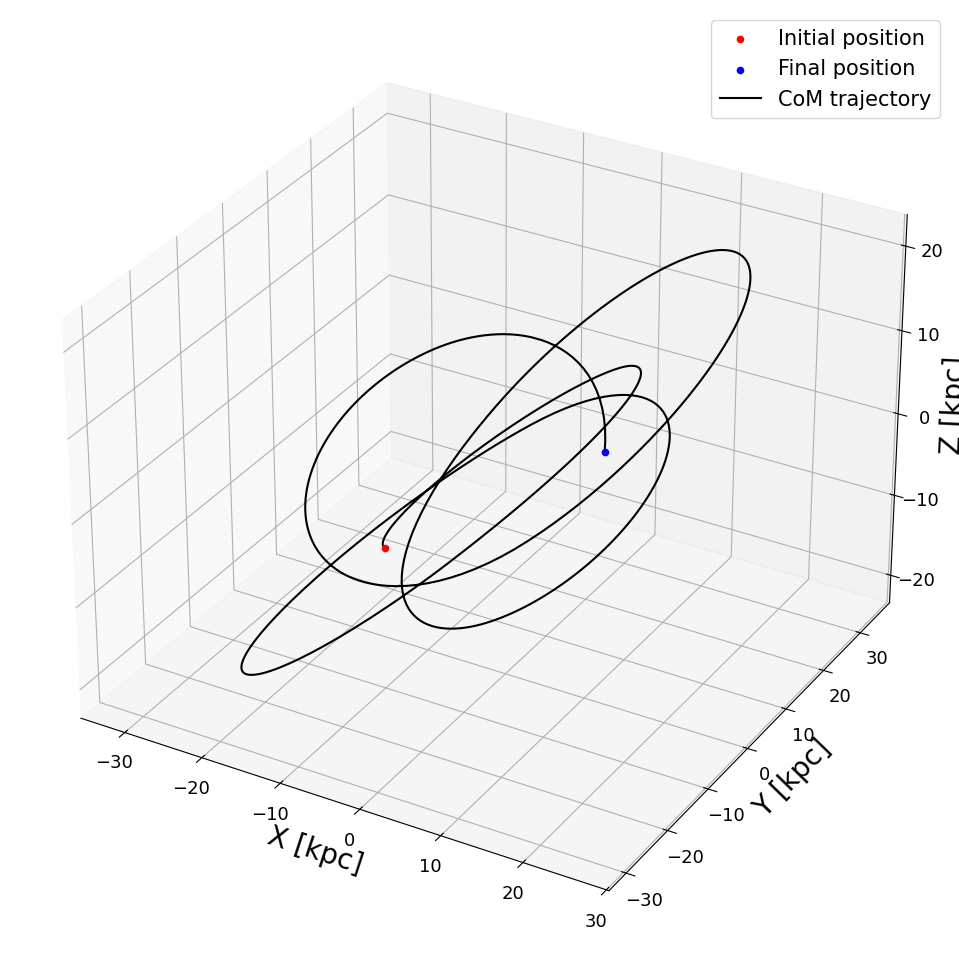

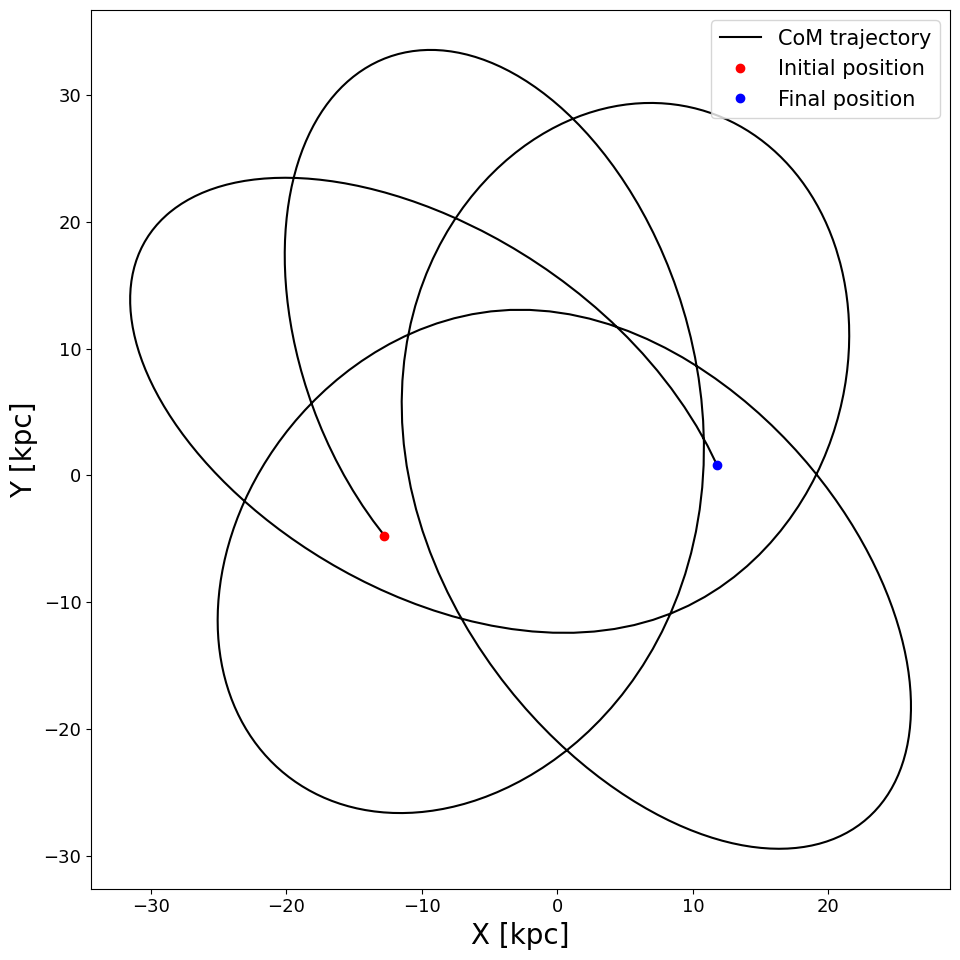

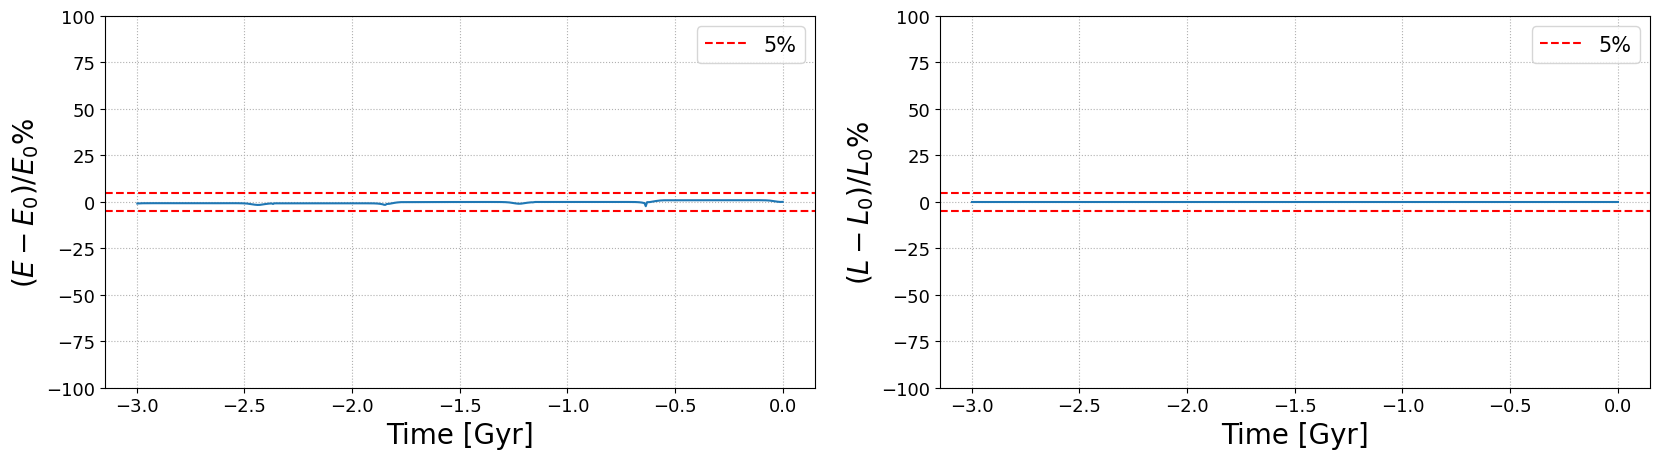

In [3]:
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

In [4]:
#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

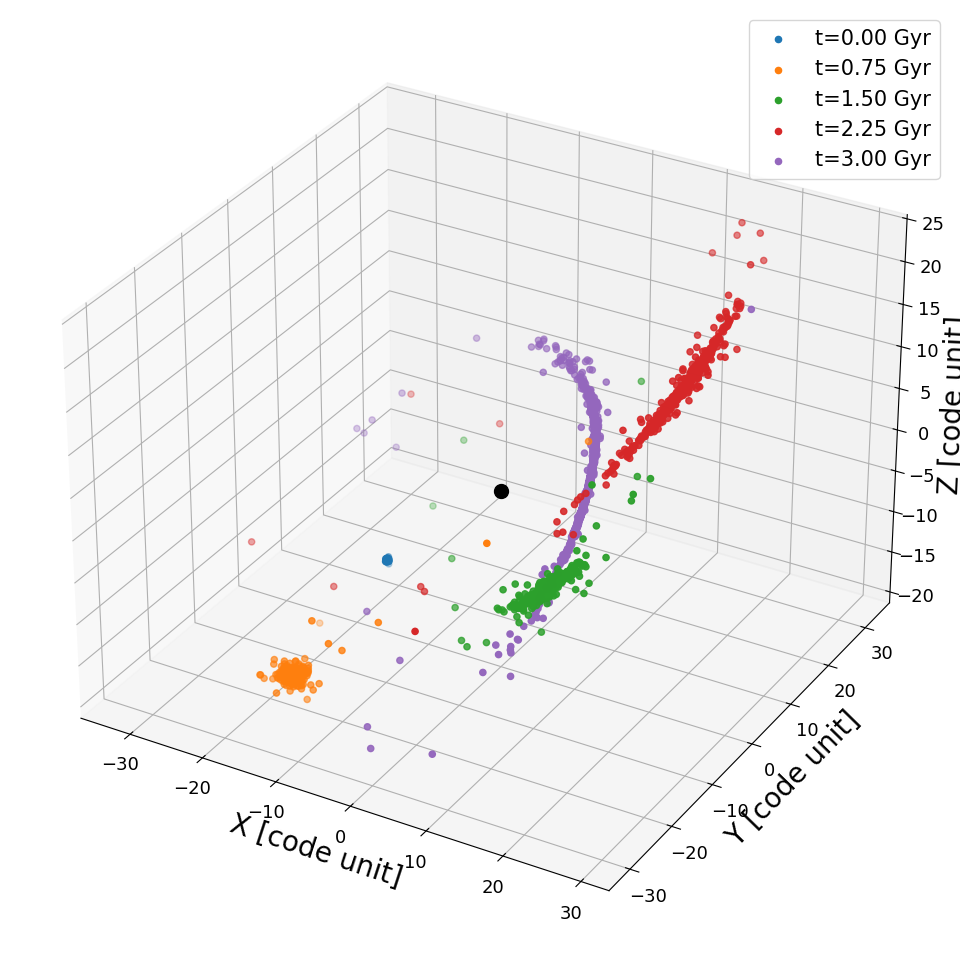

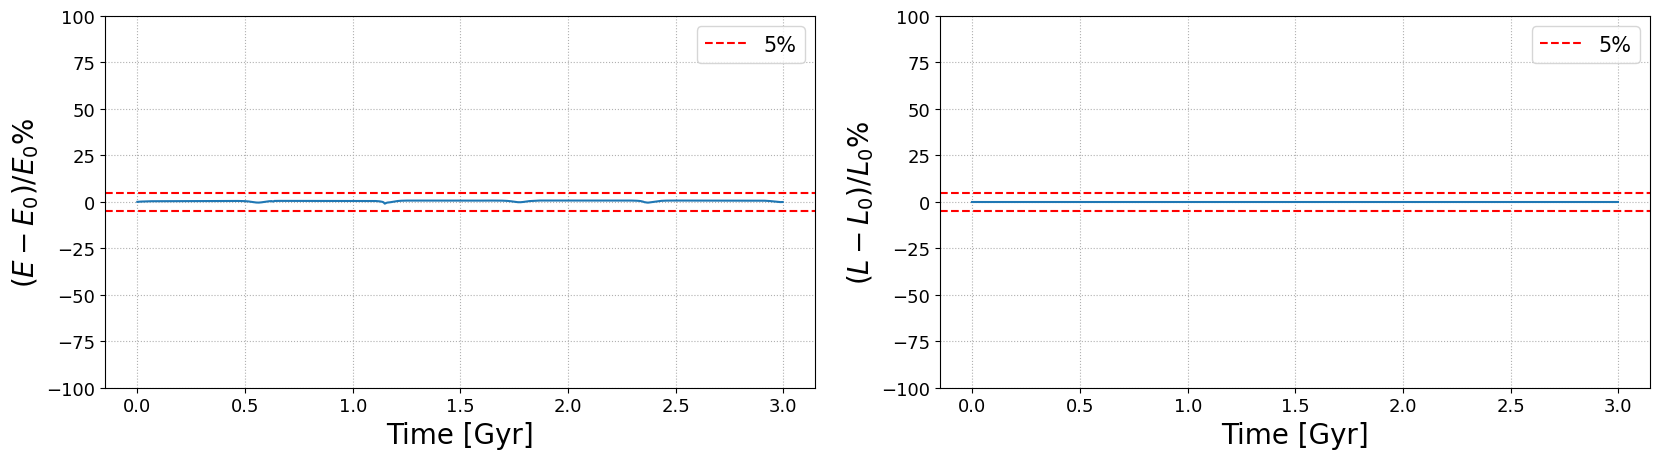

In [5]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


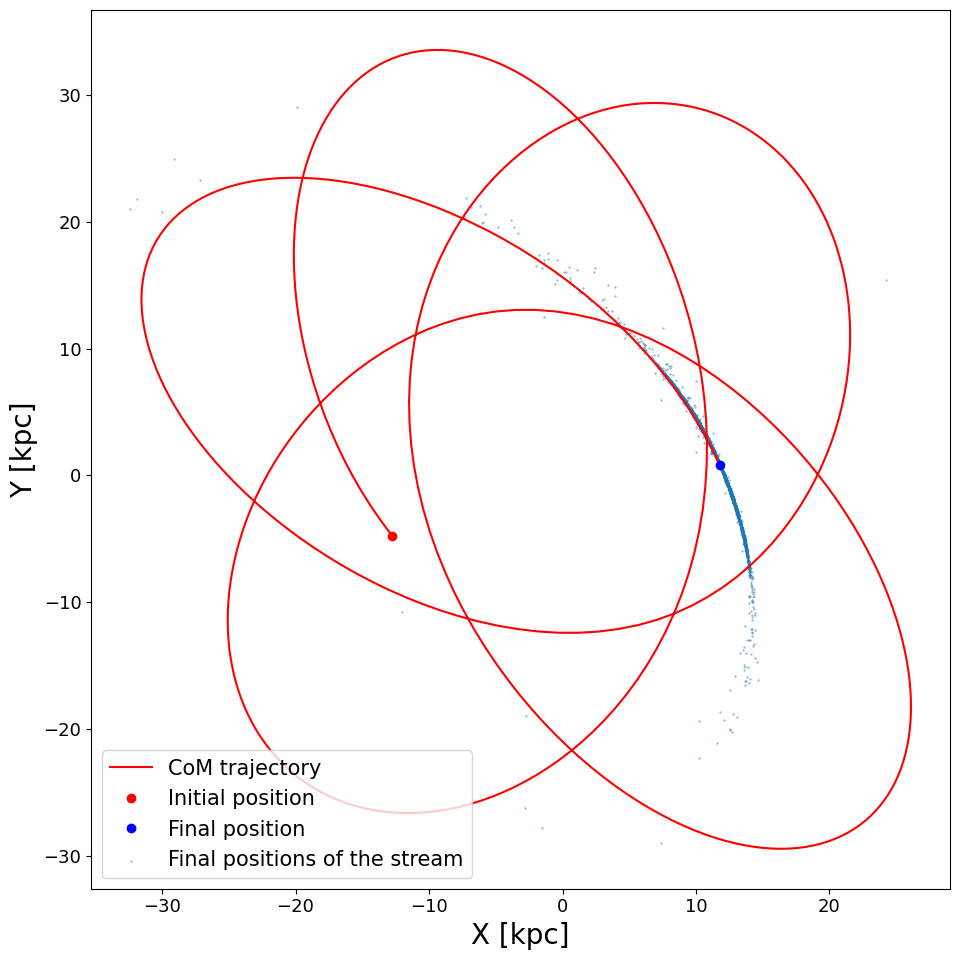

In [6]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()

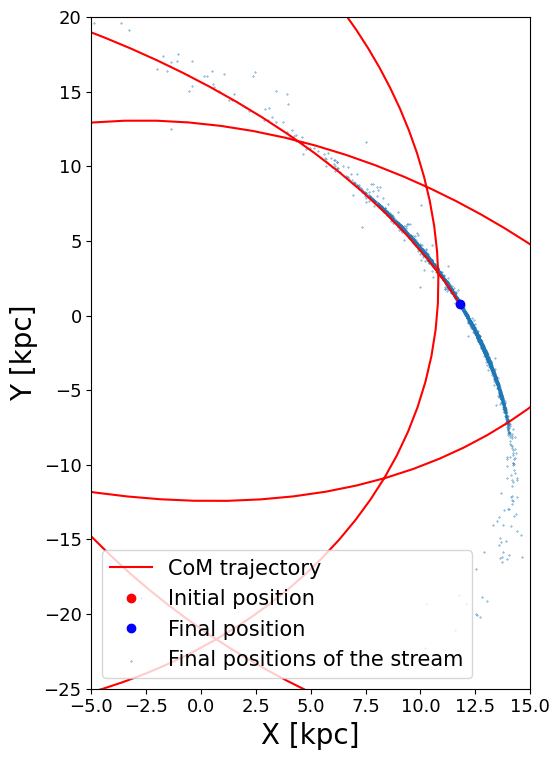

In [7]:
fig = plt.figure(figsize=(6, 8), tight_layout=True)
ax = fig.add_subplot(111)
conversion = code_units.code_length.to(u.kpc)
ax.plot(snapshots_com.states[:, 0, 0, 0]*conversion, 
        snapshots_com.states[:, 0, 0, 1]* conversion, 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]*conversion,
         snapshots_com.states[-1, 0, 0, 1]*conversion, 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]*conversion, 
        snapshots_com.states[0, 0, 0, 1]*conversion, 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]*conversion, 
           snapshots.states[-1, :, 0, 1]*conversion, s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-5, 15)
ax.set_ylim(-25, 20)
ax.legend()

In [8]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

(-250.0, 250.0)

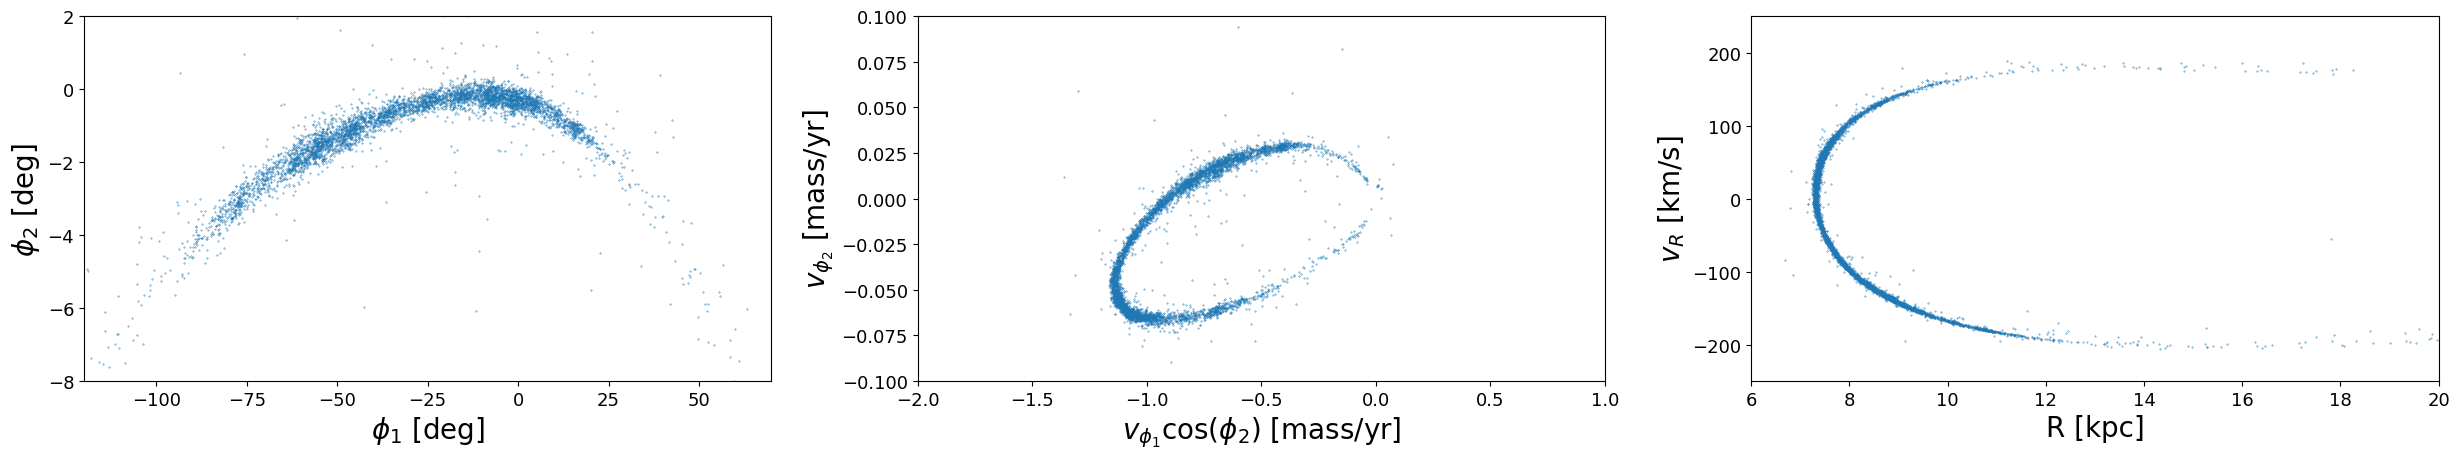

In [9]:
s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


/tmp/ipykernel_3131432/3570116978.py:21: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
/tmp/ipykernel_3131432/3570116978.py:31: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
/tmp/ipykernel_3131432/3570116978.py:40: RuntimeWarning: divide by zero encountered in log10
  im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')


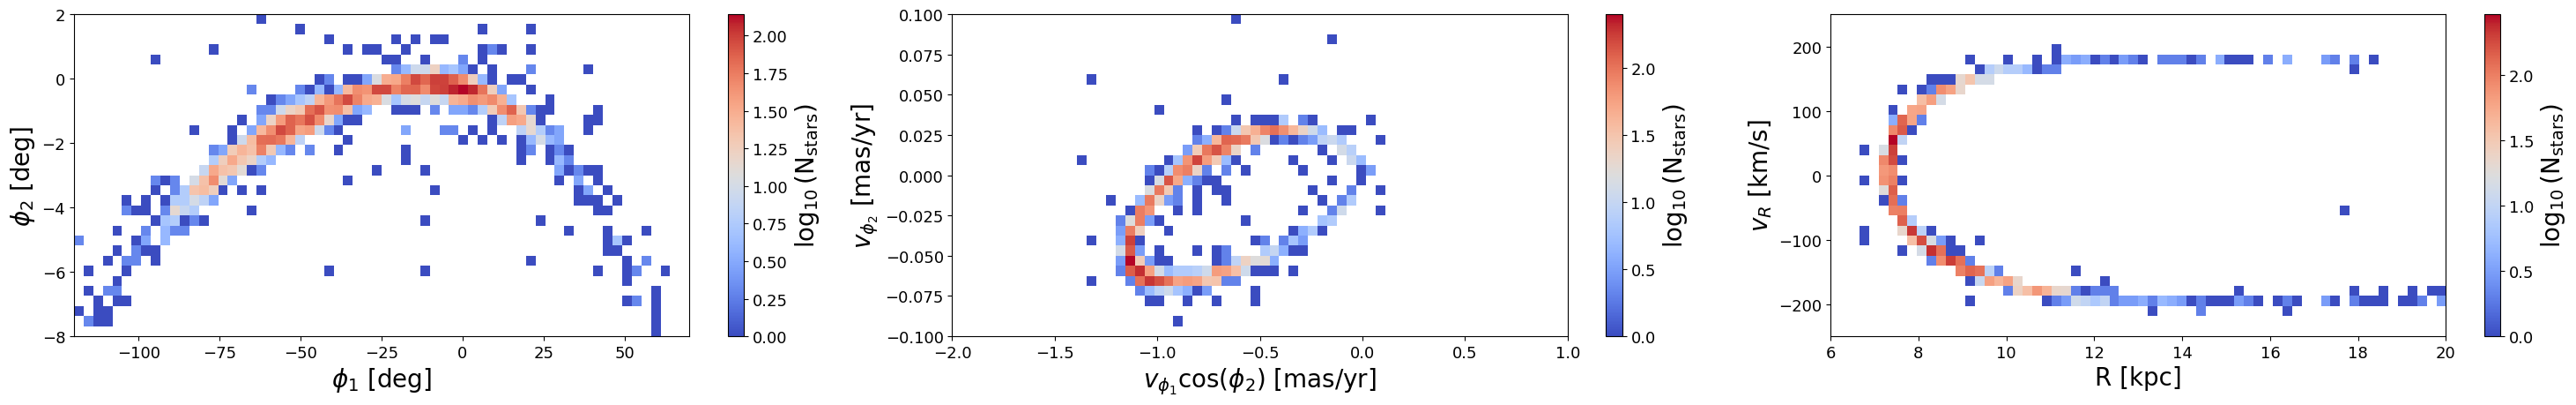

In [10]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30, 5), tight_layout=True)

# Define bin edges and create meshgrids
phi1_bins = jnp.linspace(-120, 70, 65)    # 64 bins
phi2_bins = jnp.linspace(-8, 2, 33)       # 32 bins
v1_bins = jnp.linspace(-2., 1.0, 65)      # 64 bins  
v2_bins = jnp.linspace(-0.10, 0.10, 33)   # 32 bins
R_bins = jnp.linspace(6, 20, 65)          # 64 bins
vR_bins = jnp.linspace(-250, 250, 33)     # 32 bins

# Create meshgrids for bin edges (not centers)
PHI1, PHI2 = jnp.meshgrid(phi1_bins, phi2_bins, indexing='ij')
V1, V2 = jnp.meshgrid(v1_bins, v2_bins, indexing='ij')
R_GRID, VR_GRID = jnp.meshgrid(R_bins, vR_bins, indexing='ij')

# Create 2D histograms
ax = fig.add_subplot(131)
counts1 = jnp.histogram2d(phi1, phi2, bins=[phi1_bins, phi2_bins])[0]
im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
# Define a normalization that centers white at 0
plt.colorbar(im1, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$',  )

ax = fig.add_subplot(132)
counts2 = jnp.histogram2d(v1_cosphi2, v2, bins=[v1_bins, v2_bins])[0]
im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

ax = fig.add_subplot(133)
counts3 = jnp.histogram2d(R, vR, bins=[R_bins, vR_bins])[0]
im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

# Learning the distribution with a NF

In [11]:
from flowjax.bijections import RationalQuadraticSpline
from flowjax.distributions import Normal
from flowjax.flows import masked_autoregressive_flow
from flowjax.tasks import two_moons
from flowjax.train import fit_to_data

In [12]:
#steream stacking and standardization
stream = jnp.stack((R, phi1, phi2, vR, v1_cosphi2, v2),).T
stream_mean = jnp.mean(stream, axis=0)
stream_std = jnp.std(stream, axis=0)
stream = (stream - stream_mean) / stream_std  # Standardize the data

#rng
rng = jax.random.key(0)


# create the flow
subkey, rng = jax.random.split(rng)
flow = masked_autoregressive_flow(
    subkey,
    base_dist=Normal(jnp.zeros(stream.shape[1])),
    transformer=RationalQuadraticSpline(knots=8, interval=4),
)

key, subkey = jax.random.split(key)
flow, losses = fit_to_data(subkey, flow, stream, learning_rate=1e-3)


  0%|          | 0/100 [00:00<?, ?it/s]2025-06-07 19:26:35.146760: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-07 19:26:35.146822: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-06-07 19:26:35.146840: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
 32%|███▏      | 32/10

In [13]:
log_likelihood, grad = jax.value_and_grad(flow.log_prob)(jnp.ones((6)))
print(log_likelihood)
print(grad)

-50.993225
[ 13.983143  -41.300793   -4.237853  -20.228283    7.3245444   6.3663845]


In [14]:
log_likelihood, grad = jax.vmap(jax.value_and_grad(flow.log_prob))(jnp.ones((5, 6)))
print('We can compute the log likelihood and gradient for a batch of data points')
print(log_likelihood)
print(grad)

2025-06-07 19:27:02.318903: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.


We can compute the log likelihood and gradient for a batch of data points
[-50.99604 -50.99604 -50.99604 -50.99604 -50.99604]
[[ 13.984816  -41.303677   -4.2409563 -20.214355    7.319563    6.3828754]
 [ 13.984816  -41.303677   -4.2409563 -20.214355    7.319563    6.3828754]
 [ 13.984816  -41.303677   -4.2409563 -20.214355    7.319563    6.3828754]
 [ 13.984816  -41.303677   -4.2409563 -20.214355    7.319563    6.3828754]
 [ 13.984816  -41.303677   -4.2409563 -20.214355    7.319563    6.3828754]]


In [15]:
# discarded idea of plotting the log probability density in 6D, and then projecting it in 2D
# ax = fig.add_subplot(333)
# mesh_n = 30
# xx, yy, zz, ww, vv, uu = jnp.meshgrid(
#     (jnp.linspace(6, 20, mesh_n)-stream_mean[0])/stream_std[0],
#     (jnp.linspace(-120, 70, mesh_n)-stream_mean[1])/stream_std[1],
#     (jnp.linspace(-8, 2, mesh_n)-stream_mean[2])/stream_std[2],
#     (jnp.linspace(-250, 250, mesh_n)-stream_mean[3])/stream_std[3],
#     (jnp.linspace(-2., 1.0, mesh_n)-stream_mean[4])/stream_std[4],
#     (jnp.linspace(-0.10, 0.10, mesh_n)-stream_mean[5])/stream_std[5],
#     indexing='ij'
# )

# flow_log_prob_lax = lambda x: flow.log_prob(x)
# # log_prob = flow.log_prob(jnp.stack((xx, yy, zz, ww, vv, uu), axis=-1))
# log_prob = jax.lax.map(
#     flow_log_prob_lax, 
#     jnp.stack((xx, yy, zz, ww, vv, uu), axis=-1).reshape(-1, 6),
#     batch_size = 2000).reshape((mesh_n, mesh_n, mesh_n, mesh_n, mesh_n, mesh_n))
# log_prob_yz = jnp.sum(log_prob, axis=(0, 3, 4, 5))
# ax.pcolormesh(
#     (yy[:, :, 0, 0, 0, 0]*stream_std[1] + stream_mean[1]) , (zz[:, :, 0, 0, 0, 0]*stream_std[2] + stream_mean[2]), 
#     jnp.log(-log_prob_yz), cmap='coolwarm', shading='auto'
# )
# ax.set_title("Log probability density")
# ax.set_xlabel("$\phi_1$ [deg]")
# ax.set_ylabel("$\phi_2$ [deg]")

# Plotting results of the NF

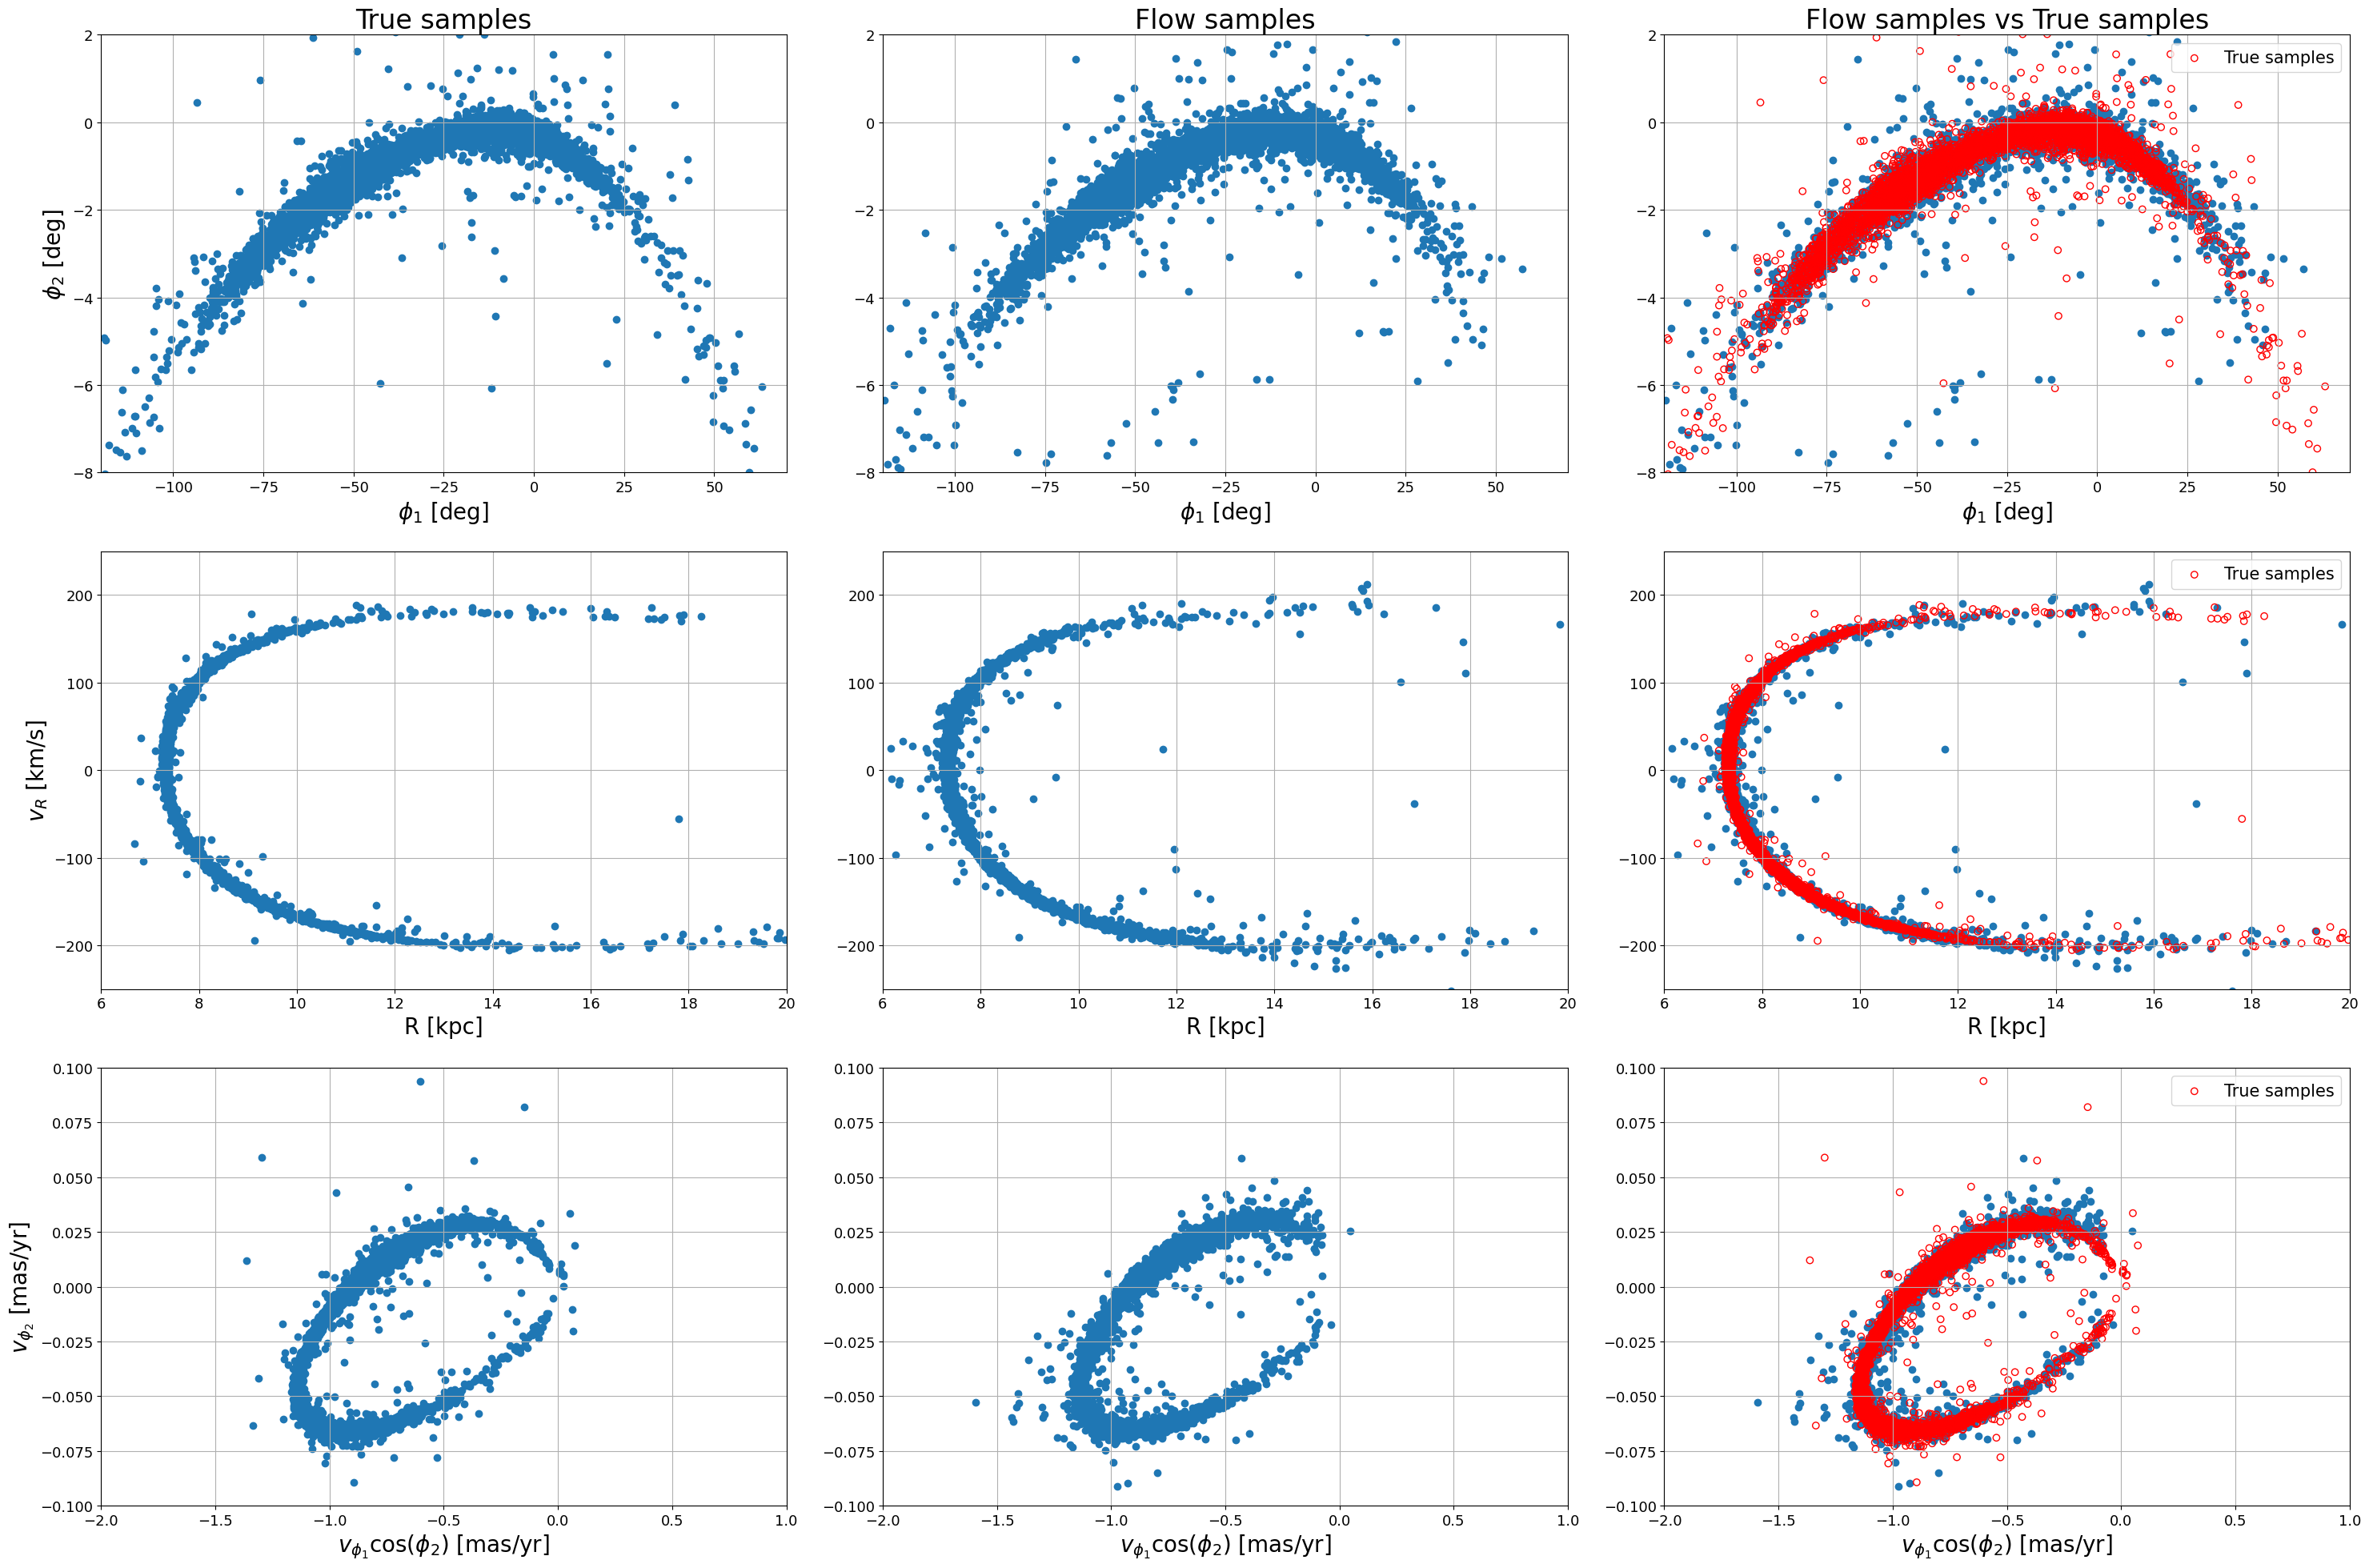

In [16]:
key, subkey = jax.random.split(jax.random.key(1))
x_samples = flow.sample(subkey, (stream.shape[0],))

# Transform the samples back to the original scale
x_samples_plot = x_samples * stream_std + stream_mean
stream_plot = stream * stream_std + stream_mean

fig = plt.figure(figsize=(30, 20), tight_layout=True)
ax = fig.add_subplot(331)
ax.scatter(stream_plot[:, 1], stream_plot[:, 2], )
ax.set_title("True samples")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.grid('dotted')
ax = fig.add_subplot(332)
ax.scatter(x_samples_plot[:, 1], x_samples_plot[:, 2], )
ax.set_title("Flow samples")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.set_xlabel("$\phi_1$ [deg]")
ax.grid('dotted')
ax = fig.add_subplot(333)
ax.set_title("Flow samples vs True samples")
ax.scatter(x_samples_plot[:, 1], x_samples_plot[:, 2],)
ax.scatter(stream_plot[:, 1], stream_plot[:, 2],  marker='o', facecolors='none',  color='r', label='True samples')
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
ax.legend()
ax.set_xlabel("$\phi_1$ [deg]")
ax.grid('dotted')

ax = fig.add_subplot(334)
ax.scatter(stream_plot[:, 0], stream_plot[:, 3], )
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.grid('dotted')
ax = fig.add_subplot(335)
ax.scatter(x_samples_plot[:, 0], x_samples_plot[:, 3], )
ax.set_xlabel("R [kpc]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.grid('dotted')
ax = fig.add_subplot(336)
ax.scatter(x_samples_plot[:, 0], x_samples_plot[:, 3], )
ax.scatter(stream_plot[:, 0], stream_plot[:, 3], marker='o', facecolors='none', color='r', label='True samples')
ax.set_xlabel("R [kpc]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
ax.legend()
ax.grid('dotted')

ax = fig.add_subplot(337)
ax.scatter(stream_plot[:, 4], stream_plot[:, 5], )
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")      
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax = fig.add_subplot(338)
ax.scatter(x_samples_plot[:, 4], x_samples_plot[:, 5], )
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax = fig.add_subplot(339)
ax.scatter(x_samples_plot[:, 4], x_samples_plot[:, 5], )
ax.scatter(stream_plot[:, 4], stream_plot[:, 5], marker='o', facecolors='none', color='r', label='True samples')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
ax.grid('dotted')
ax.legend()

plt.tight_layout()
plt.show()

In [17]:
# Sanity check tha the likelihood of the training set is HIGHER than the likelihood of the samples

log_prob_stream = flow.log_prob(stream)
log_prob_samples = flow.log_prob(x_samples)
print("Log probability of the training set:", jnp.sum(log_prob_stream))
print("Log probability of the samples:", jnp.sum(log_prob_samples))
print("Is the log probability of the training set higher than the log probability of the samples?", jnp.sum(log_prob_stream) > jnp.sum(log_prob_samples))


Log probability of the training set: 48494.76
Log probability of the samples: 45335.36
Is the log probability of the training set higher than the log probability of the samples? True


# Loss with the simulator and the NF

Let's see if the Likelihood learned by the NF can be a good loss function

In [18]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_NFW_mass_grad(Mvir, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) * u.Msun.to(code_units.code_mass)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = -jnp.sum(log_prob)

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = params.NFW_params.Mvir*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_NFW_mass_grad, )(Mvir, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 0.007398151
Loss:
 -3577.3794


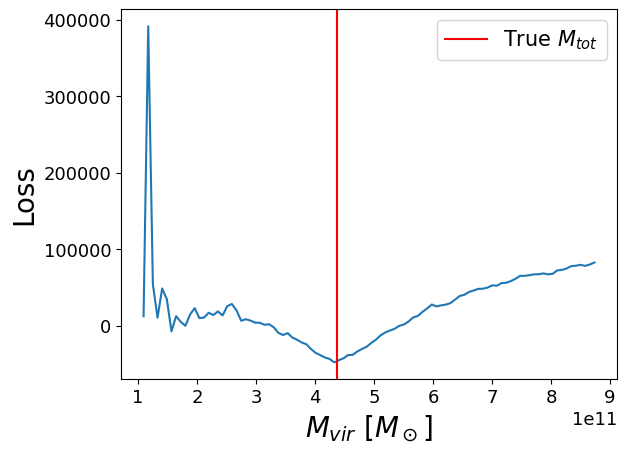

In [25]:
from jax.sharding import Mesh, PartitionSpec, NamedSharding


n_sim = 98
keys = jnp.arange(n_sim+1)
Mvir = np.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
Mvir = np.concatenate([Mvir, np.array([params.NFW_params.Mvir])]) # Append the true Mvir value
Mvir = jnp.array(np.sort(Mvir))

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)
@jit
def time_integration_NFW_mass_grad_map(Mvir_and_key):
    Mvir, key = Mvir_and_key
    return jax.value_and_grad(time_integration_NFW_mass_grad)(Mvir, key)

loss, grad = jax.lax.map(
    time_integration_NFW_mass_grad_map, 
    (Mvir_sharded, keys_sharded), 
    batch_size=2
)

plt.figure()
plt.plot(Mvir*(code_units.code_mass).to(u.Msun), loss)
plt.axvline(params.NFW_params.Mvir*(code_units.code_mass).to(u.Msun), color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
plt.ylabel('Loss')
plt.legend()


# Gradient on t_end 

In [26]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_tend_grad(t_end, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params_com = params_com._replace(t_end = -t_end,)
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) * u.Msun.to(code_units.code_mass)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = -jnp.sum(log_prob)

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = params.t_end*(3/4) 
key = 0
loss, grad = jax.value_and_grad(time_integration_tend_grad, )(t_end, key)
print("Gradient of the total mass of the t_end:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the t_end:
 51737.13
Loss:
 -45168.234


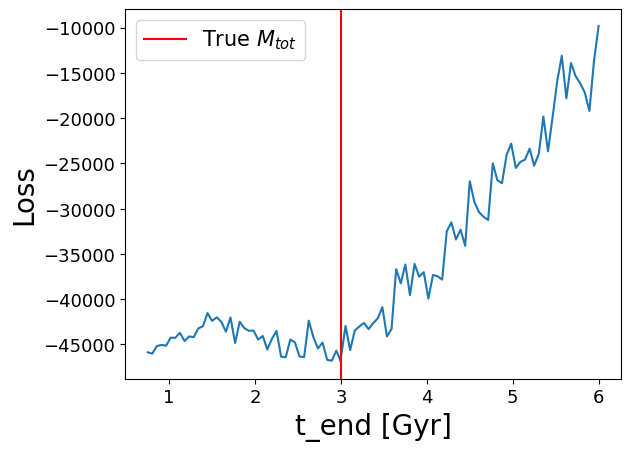

In [ ]:
n_sim = 99
keys = jnp.arange(n_sim+1)
t_end = np.linspace(params.t_end*(1/4), params.t_end*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
t_end = np.concatenate([t_end, np.array([params.t_end])]) # Append the true Mvir value
t_end = jnp.array(np.sort(t_end))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

mesh = Mesh(np.array(jax.devices()), ("i",))
t_end_sharded = jax.device_put(t_end, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

@jit
def time_integration_NFW_tend_map(t_end_and_key):
    t_end, key = t_end_and_key
    return jax.value_and_grad(time_integration_tend_grad)(t_end, key)

loss, grad = jax.lax.map(
    time_integration_NFW_tend_map, 
    (t_end_sharded, keys_sharded), 
    batch_size=1,
)

plt.figure()
plt.plot(t_end*(code_units.code_time).to(u.Gyr), loss)
plt.axvline(params.t_end*(code_units.code_time).to(u.Gyr), color='r', label='True $M_{tot}$')
plt.xlabel("$t_{end}$  [Gyr]")
plt.ylabel('Loss')
plt.legend()


# Gradient on the loss for 2 parameters

In [28]:
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)

@jit
def time_integration_NFWmass_tend_grad(Mvir, t_end, key):

    #Creation of the Plummer sphere requires a key 
    key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(
                NFW_params=params.NFW_params._replace(
                    Mvir=Mvir 
                ))
    new_params = new_params._replace(
                t_end=t_end,  # Update the t_end parameter
                )
    
    new_params_com = params_com._replace(
                NFW_params=params_com.NFW_params._replace(
                    Mvir=Mvir 
                ))
    
    #we also update the t_end parameter for the center of mass
    new_params_com = new_params_com._replace(
                t_end=-t_end,  # Update the t_end parameter for the center of mass
                )
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) * u.Msun.to(code_units.code_mass)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #we calculate the loss as the negative log likelihood of the stream

    log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    loss = -jnp.sum(log_prob)

    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
key = 0
loss, grad = jax.value_and_grad(time_integration_NFWmass_tend_grad, argnums=(0,1))(Mvir, t_end, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 (Array(-0.00577366, dtype=float32), Array(792336., dtype=float32))
Loss:
 19745.219


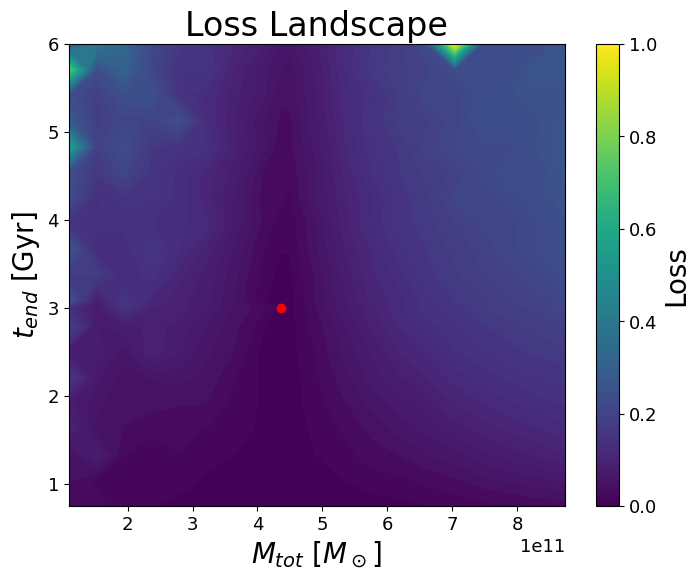

In [34]:
n_sim = 20

M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales

M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# Ensure both arrays are sorted
M_tot_values = jnp.sort(M_tot_values)
t_end_values = jnp.sort(t_end_values)


# Create a meshgrid
M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()
keys_flat = jnp.arange(len(Mvir_flat))  # Create a flat array of keys

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, t_end, key = input
    return jax.value_and_grad(time_integration_NFWmass_tend_grad, argnums=[0, 1, ])(Mvir, t_end, key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
                         batch_size=1)

loss = loss.reshape(M_tot_grid.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=100, cmap="viridis")
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", label="True values")
plt.colorbar(label="Loss")
plt.xlabel("$M_{tot}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("Loss Landscape")
plt.show()